<a href="https://colab.research.google.com/github/iyzg/nca-maze/blob/main/maze-create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training NCA to solve mazes

Ivy Zhang | 2023

Preliminary experiment to take a NCA implementation and apply it to a maze! If this works, I'll try and automate the generation of mazes and see if NCA can learn a general solution to mazes.

Inspiration & Code Starter: https://github.com/greydanus/studying_growth

In [ ]:
# Neural CA | Sam Greydanus | 2020
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import time, PIL.Image, io, requests, copy

def get_dataset(k=16):
  r = requests.get('https://raw.githubusercontent.com/iyzg/nca-maze/main/data/maze-2.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((16, 16), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha  
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

def make_circle_masks(n, h, w):
  x = torch.linspace(-1.0, 1.0, w)[None, None, :]
  y = torch.linspace(-1.0, 1.0, h)[None, :, None]
  center = torch.rand(2, n, 1, 1)-.5
  r = 0.3 * torch.rand(n, 1, 1) + 0.1
  x, y = (x-center[0])/r, (y-center[1])/r
  return 1-(x*x+y*y < 1.0).float()  # mask is OFF in circle

# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=16, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  # TODO: Need to make alive_mask also mask out all parts of maze that are illegal
  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps

def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, args, data):
  model = model.to(args.device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
  scheduler = MultiStepLR(optimizer, milestones=args.milestones, gamma=args.gamma)

  target_rgba = torch.Tensor(data['y']).to(args.device)  # put the target image on GPU
  init_state = torch.zeros(args.batch_size, args.state_dim, *target_rgba.shape[-2:]).to(args.device)
  # TODO: Need to make init the start of maze
  init_state[..., 16, 16] = 1.
  # init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.  # initially, there is just one cell
  pool = init_state[:1].repeat(args.pool_size,1,1,1)
  
  results = {'loss':[], 'tprev': [time.time()]}
  for step in range(args.total_steps+1):

    # prepare batch, perturb, and run forward pass
    if args.pool_size > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(args.pool_size, size=[args.batch_size])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state
    if args.perturb_n > 0:  # perturb CAs (if desired)
      perturb = make_circle_masks(args.perturb_n, *init_state.shape[-2:])[:, None, ...]
      input_states[-args.perturb_n:] *= perturb.to(args.device)

    states = model(input_states, np.random.randint(*args.num_steps))  # forward pass
    final_rgba = states[-1,:, :4]  # grab rgba channels of last frame

    # compute loss and run backward pass
    mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
    batch_mses = mses.view(args.batch_size,-1).mean(-1)
    loss = batch_mses.mean()
    loss.backward() ; normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if args.pool_size > 0:
      final_states = states[-1].detach()
      final_states[batch_mses.argmax()] = init_state[:1]
      pool[pool_ixs] = final_states

    # bookkeeping and logging
    results['loss'].append(loss.item())
    if step % args.print_every == 0:
      print('step {}, dt {:.3f}s, loss {:.2e}, log10(loss) {:.2f}'\
          .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))
      results['tprev'].append(time.time())

  results['final_model'] = copy.deepcopy(model.cpu())
  return results

# Organize hyperparameters in a sane way
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_args(as_dict=False):
  arg_dict = {'state_dim': 16,        # first 4 are rgba, rest are latent
              'hidden_dim': 128,
              'num_steps': [64, 96],
              'pool_size': 0,         # pool of persistent CAs (defaults are 0 and 1000)
              'perturb_n': 0,         # num. of CAs to perturb (defaults are 0 and 3)
              'batch_size': 8,
              'learning_rate': 2e-3, 
              'milestones': [1500],   # lr scheduler milestones
              'gamma': 0.25,          # lr scheduler gamma
              'print_every': 100,
              'total_steps': 2000,
              'device': 'cuda',       # options are {"cpu", "cuda"}
              'seed': 42}             # the meaning of life (for these little guys)
  return arg_dict if as_dict else ObjectView(arg_dict)

In [ ]:
data = get_dataset()
print(data['y'][0][1][16][16])

0.54509807


In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')
project_dir = "/content/gdrive/My Drive/05 Research/nca-maze/"

def to_pickle(thing, path):  # save something
  with open(path, 'wb') as handle:
      pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)

def from_pickle(path):  # load something
  thing = None
  with open(path, 'rb') as handle:
      thing = pickle.load(handle)
  return thing

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
configs = [{'pool_size': 0, 'perturb_n': 0, 'name': 'grow'},
           {'pool_size': 1000, 'perturb_n': 0, 'name': 'persist'},
           {'pool_size': 1000, 'perturb_n': 3, 'name': 'regenerate'}]

for config in configs:
  print("\n#### Training CA model '{}': pool_size: {}, perturb_n: {} ####"\
        .format(config['name'], config['pool_size'], config['perturb_n']))
  args = get_args()  # instantiate args, then everything else, then run
  args.pool_size = config['pool_size']
  args.perturb_n = config['perturb_n']
  [f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
  model = CA(args.state_dim, args.hidden_dim)
  results = train(model, args, data=get_dataset())

  run_tag = 'ca_{}.pkl'.format(config['name'])
  to_pickle(results, path=project_dir + run_tag)


#### Training CA model 'grow': pool_size: 0, perturb_n: 0 ####
step 0, dt 0.155s, loss 4.15e-01, log10(loss) -0.38
step 100, dt 10.303s, loss 3.72e-02, log10(loss) -1.43
step 200, dt 10.209s, loss 3.72e-02, log10(loss) -1.43
step 300, dt 10.522s, loss 3.72e-02, log10(loss) -1.43
step 400, dt 10.038s, loss 3.72e-02, log10(loss) -1.43
step 500, dt 10.452s, loss 3.72e-02, log10(loss) -1.43
step 600, dt 10.411s, loss 3.72e-02, log10(loss) -1.43
step 700, dt 10.404s, loss 3.72e-02, log10(loss) -1.43
step 800, dt 9.905s, loss 3.72e-02, log10(loss) -1.43
step 900, dt 10.254s, loss 3.72e-02, log10(loss) -1.43
step 1000, dt 10.500s, loss 3.72e-02, log10(loss) -1.43
step 1100, dt 9.991s, loss 3.72e-02, log10(loss) -1.43
step 1200, dt 10.228s, loss 3.72e-02, log10(loss) -1.43
step 1300, dt 10.460s, loss 3.72e-02, log10(loss) -1.43
step 1400, dt 10.293s, loss 3.72e-02, log10(loss) -1.43
step 1500, dt 9.695s, loss 3.72e-02, log10(loss) -1.43
step 1600, dt 10.101s, loss 3.72e-02, log10(loss) -1.43


In [ ]:
results = from_pickle(path=project_dir + 'ca_grow.pkl')
model = results['final_model']

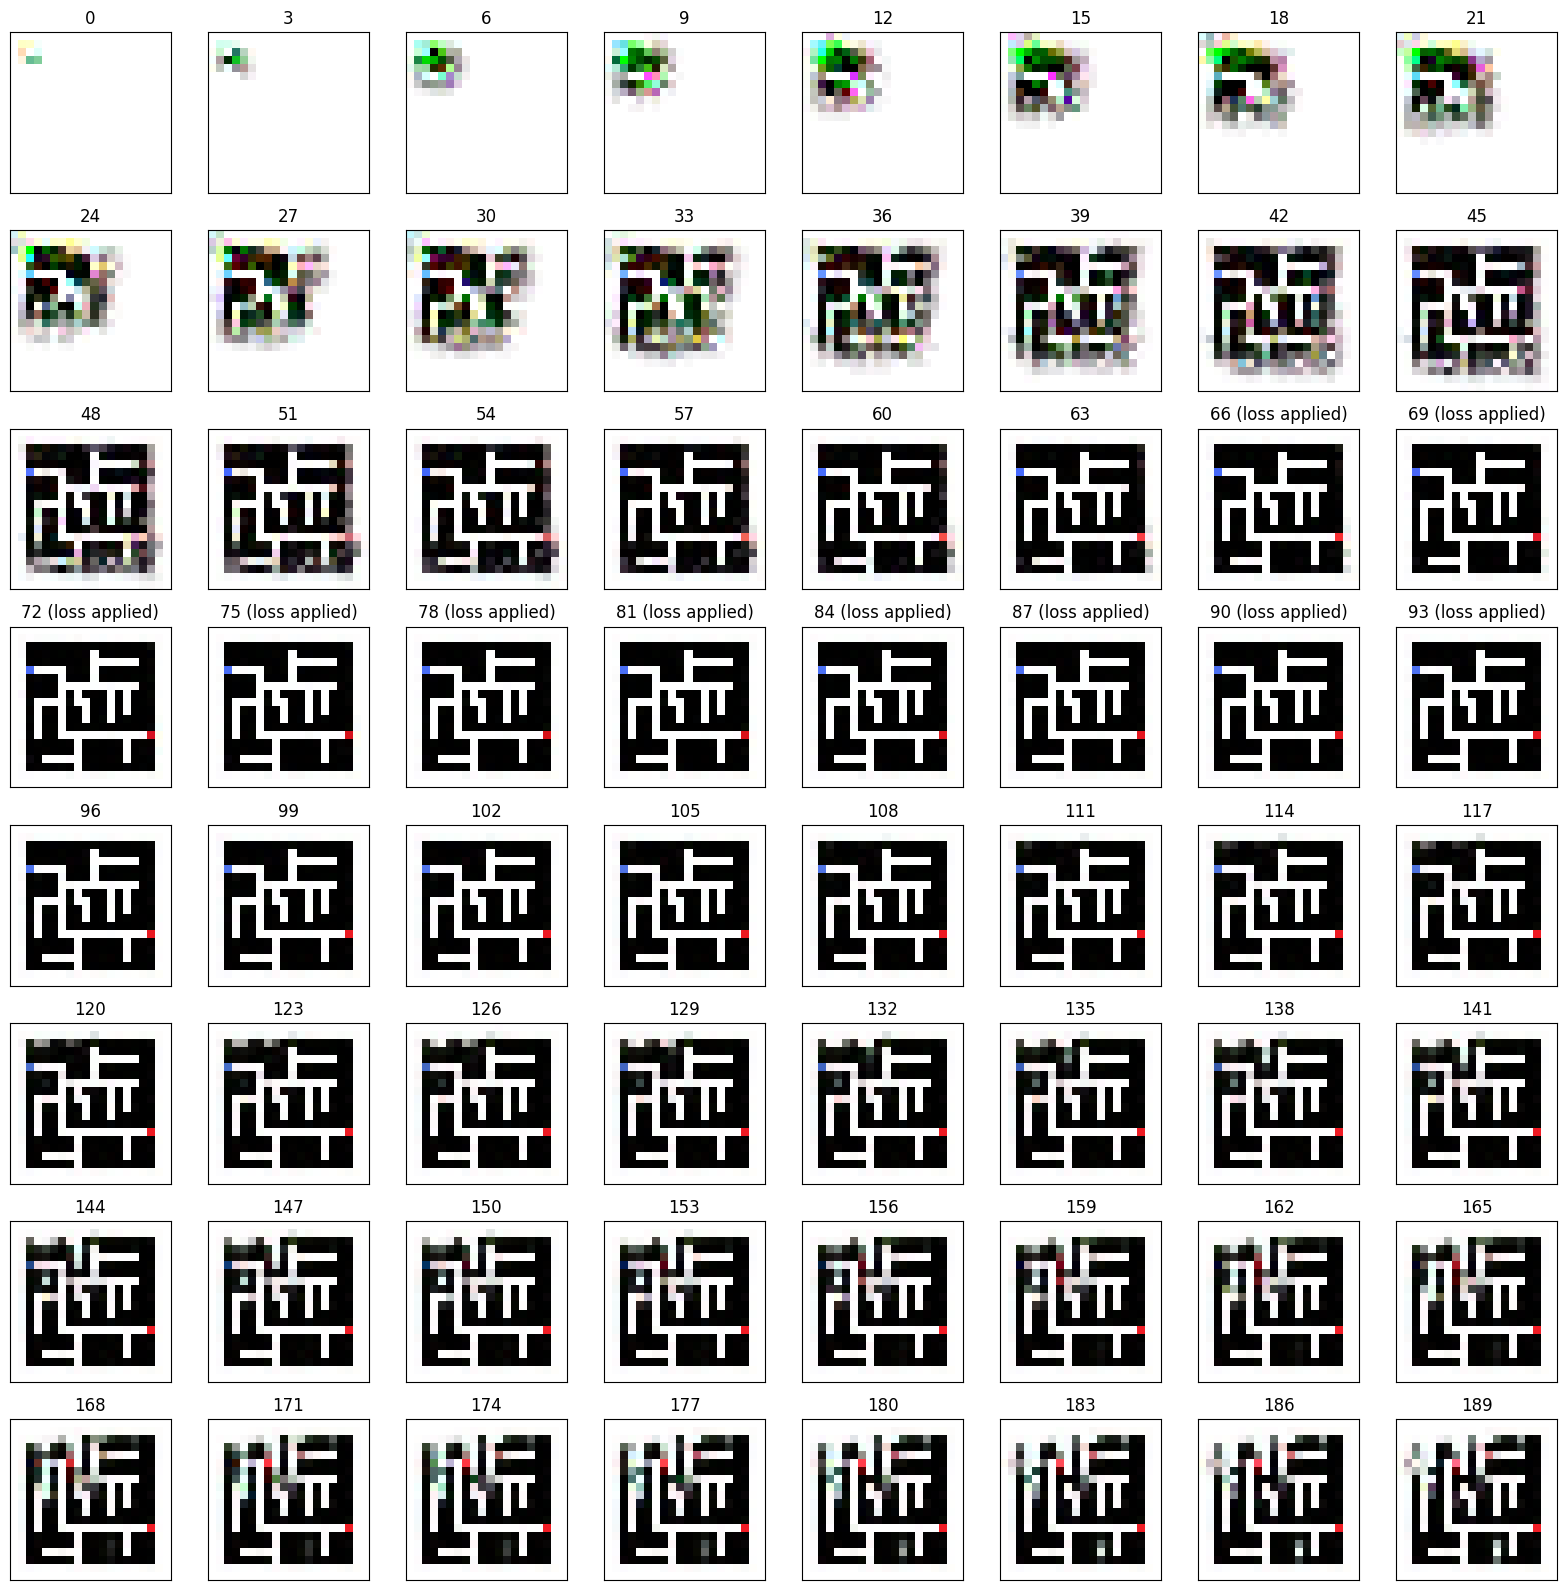

In [ ]:
def zoom(x, k=14):
  return x[...,k:-k,k:-k]

def to_rgb(x):
  rgb, a = x[..., :3,:,:], x[..., 3:4,:,:].clip(0,1)
  return 1.0-a+rgb  # assume rgb premultiplied by alpha
  
# Visualize the dynamics of our learned CA
data = get_dataset()
init_state = torch.zeros(1, args.state_dim, *data['y'].shape[-2:])
init_state[..., 16, 16] = 1.
# init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.

plot_every = 3
frames = model.cpu()(init_state, 200).detach().numpy()
frames = zoom(to_rgb(frames))[::plot_every]

rows, cols = 8, 8
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      if plot_every*(ix-1) > args.num_steps[0] and plot_every*(ix-1) < args.num_steps[1]:
        plt.title('{} (loss applied)'.format(plot_every*(ix-1)))
      plt.imshow(frames[ix-1,0].transpose(1,2,0).clip(0,1))

plt.tight_layout() ; plt.show()